# Using cavity gain to improve fidelity of dynamical entanglement


In [2]:
# run this unit first. this unit includes all functions that we used.

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import time
import math


# operators
N = 2 # two-level emitter
Na = 16 # cavity photon truncation, ensure Na >> <a^+a> = P/(kappa-P)
sigma_1 = tensor(sigmam(), qeye(N), qeye(Na)) # lowering operator for emitter 1
sigma_2 = tensor(qeye(N), sigmam(), qeye(Na)) # lowering operator for emitter 2
N1 = sigma_1.dag() * sigma_1 
N2 = sigma_2.dag() * sigma_2
S = sigma_1 + sigma_2 # collective operator
a = tensor(qeye(N), qeye(N), destroy(Na)) # photon annihilation operator 

# states
psi_0 = tensor(basis(N, 0), basis(N, 1), basis(Na,0)) # initial state |100>
phi = (tensor(basis(N, 0), basis(N, 1)) - 1j* tensor(basis(N, 1), basis(N, 0))) * 2**-0.5 
# target state |phi>=(|10>-i|01>)/sqrt(2)

# operators and states after tracing the cavity mode
sigma_1_eff = tensor(sigmam(), qeye(N)) # lowering operator for emitter 1
sigma_2_eff = tensor(qeye(N), sigmam()) # lowering operator for emitter 2
N1_eff = sigma_1_eff.dag() * sigma_1_eff
N2_eff = sigma_2_eff.dag() * sigma_2_eff
S_eff = sigma_1_eff + sigma_2_eff # collective operator
psi_0_eff = tensor(basis(N, 0), basis(N, 1))

# define functions to calculate the master equation
def dP_dynamics_full(): 
    H_full = Delta * (N1 + N2) + g * (a*S.dag() + a.dag()*S) # origin Hamiltonian
    colps_full = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a] # Lindblad term
    data_full = mesolve(H_full, psi_0, times, colps_full, []) # solve the master equation, get the solution for \rho
    rho_full = data_full.states # the solution rho(t)
    F_full = [fidelity(phi, state.ptrace((0, 1))) for state in data_full.states] # calculate the fidelity for rho(t) that we get from data_full.states
    N_aa = [expect(a.dag() * a, state) for state in data_full.states] # calculate the average photon number
    return F_full, N_aa # output

def dP_dynamics_eff():# define this function for fidelity by solving effective master equation
    H_eff = Delta * (N1_eff + N2_eff) + J_kappa * S_eff.dag() * S_eff + J_P * S_eff * S_eff.dag() # effective Hamiltonian
    colps_eff = [math.sqrt(gamma) * sigma_1_eff, math.sqrt(gamma) * sigma_2_eff, math.sqrt(Gamma_kappa) * S_eff, math.sqrt(Gamma_P) * S_eff.dag()] # Lindblad terms
    data_eff = mesolve(H_eff, psi_0_eff, times, colps_eff, []) # solve master equation
    F_eff = [fidelity(phi, state) for state in data_eff.states] # calculate the fidelity for rho(t) that we get from data_eff.states
    return F_eff # output

print('functions are ready')

functions are ready


runing time：17.81 s


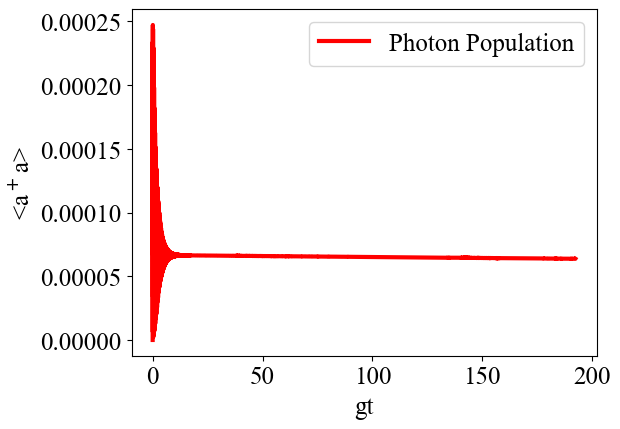

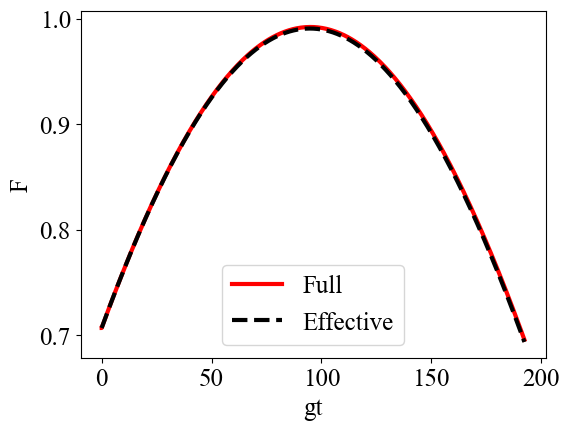

In [4]:
# This unit is for the dynamics

# Start timing
start_time = time.time()

# parameters
g = 1 # unit 1
kappa = 1 * g # fixed kappa. can be tuned in the range of kappa<<Delta
C = 10**4 # cooperativity, much larger than 1
gamma = g**2 / kappa / C
P = 0.5 * kappa # cavity gain, smaller than kappa, and ensure Na >> P/(kappa-P)
Delta = g * ((kappa + P) / gamma)**0.5 # optimal detuning, ensure Delta >> g, kappa
J_kappa = g**2 * kappa / Delta / (kappa - P) # coherent coupling induced by cavity
J_P = - g**2 * P / Delta / (kappa - P) # coherent coupling induced by cavity
Gamma_kappa = g**2 * kappa / Delta**2 # collective decay induced by cavity
Gamma_P = g**2 * P / Delta**2 # collective decay induced by cavity
T = np.pi / (2 * (J_kappa + J_P)) # half period
Nt = int(T * 50) # time step
times = np.linspace(0, T, Nt) #time list


# solve the master equation
F_full, N_aa = dP_dynamics_full() # from full master equation
F_eff = dP_dynamics_eff() # from effective master equation


# plot figure
# if N_aa = <a^+a> << Na, it means cavity photon truncation Na is big enough
# if the curve is smooth, it means that the time division Nt is sufficiently fine
# you can increase Na and Nt to see if the curve changes.
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5)) 
plt.plot(times, N_aa, label='Photon Population', linewidth=3, linestyle='-', color='r')  
plt.xlabel('gt')
plt.ylabel('<a$^+$a>')
plt.tick_params(axis='both', which='major')
plt.legend(loc='best')

plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5)) 
plt.plot(times, F_full, label='Full', linewidth=3, linestyle='-', color='r')  
plt.plot(times, F_eff, label='Effective', linewidth=3, linestyle='--', color='k')
plt.xlabel('gt')
plt.ylabel('F')
plt.tick_params(axis='both', which='major')
plt.legend(loc='best')


# save the data in .txt file
np.savetxt('dP_F_t.txt', np.column_stack((times, F_full, F_eff)), delimiter=' ') # write data into this file with a single space separating each piece of data

# end timing
end_time = time.time()
# print the time
execution_time = end_time - start_time
print(f"runing time：{execution_time:.2f} s")

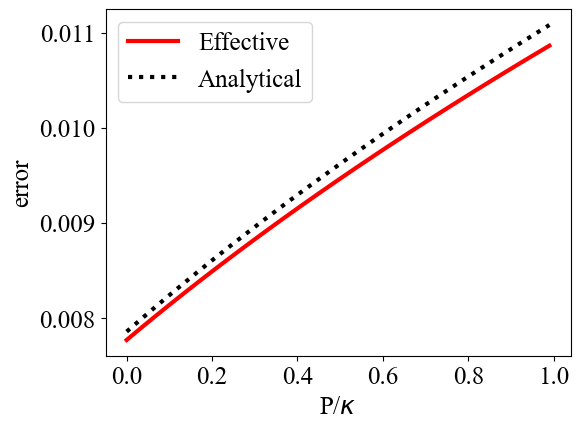

runing time：21.12 s


In [32]:
#This unit is for the scaling of P, P in [0, kappa]

# Start timing
start_time = time.time()

#parameters
g = 1 # unit 1
kappa = 1 * g # fixed kappa. can be tuned in the range of kappa<<Delta
C = 10**4 # cooperativity, much larger than 1
gamma = g**2 / kappa / C
M = 30 # data point
dP = np.linspace(0, 0.99*kappa, M)
epsilon_full = np.zeros(M) # array for saving data
epsilon_eff = np.zeros(M) # array for saving data

# calculate
for j in range (M): 
    P = dP[j] # pick each cooperativity
    Delta = g * ((kappa + P) / gamma)**0.5 # optimal detuning
    J_kappa = g**2 * kappa / Delta / (kappa - P) # coherent coupling induced by cavity
    J_P = - g**2 * P / Delta / (kappa - P) # coherent coupling induced by cavity
    Gamma_kappa = g**2 * kappa / Delta**2 # collective decay induced by cavity
    Gamma_P = g**2 * P / Delta**2 # collective decay induced by cavity
    T = np.pi / (2 * (J_kappa + J_P)) # half period
    Nt = int(T * 50) # time step
    times = np.linspace(0, T, Nt) #time list
    # for full master equation, the photon number P/(kappa-P) can be very large, hard to calculate. 
    # Since we already verify that the effective master equation is valid, let's just use effective master equatiin now.
    #epsilon_full[j] = 1 - np.max(F_full_dP(P)[0]) # solution from full master equation
    epsilon_eff[j] = 1 - np.max(dP_dynamics_eff()) # solution from effective master equation
    
epsilon_ana = np.pi / 4 * ((kappa + dP)*gamma / g**2)**0.5 # analytical solution


# plot figure
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))  # figure size 
plt.plot(dP/kappa, epsilon_eff, label='Effective', linewidth=3, linestyle='-', color='r')  
plt.plot(dP/kappa, epsilon_ana, label='Analytical', linewidth=3, linestyle=':', color='k')
plt.xlabel('P/$\kappa$')
plt.ylabel('error')
plt.tick_params(axis='both', which='major')
plt.legend(loc='best')
plt.show()


# save the data in .txt file
np.savetxt('dP_error_P.txt', np.column_stack((dP/kappa, epsilon_eff, epsilon_ana)), delimiter=' ')

# end timing
end_time = time.time()
# print the time
execution_time = end_time - start_time
print(f"runing time：{execution_time:.2f} s")